In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

### Carregando os dados dos arquivos CSV

In [2]:
df_estoque = pd.read_csv('estoque.csv')
df_vendas = pd.read_csv('vendas_exemplo.csv')

In [3]:
df_vendas['Data'] = df_vendas['Data'].astype('datetime64[ns]')
df_vendas

,Produto,Venda,Data
0,1,2,2024-03-27
1,1,3,2024-03-27
2,1,4,2024-03-28
3,1,1,2024-03-28
4,1,7,2024-03-29
5,3,5,2024-03-29
6,1,1,2024-03-29
7,1,2,2024-03-30
8,1,1,2024-03-30
9,1,10,2024-03-31


Text(0.5, 1.0, 'Numero de Vendas x Dia')

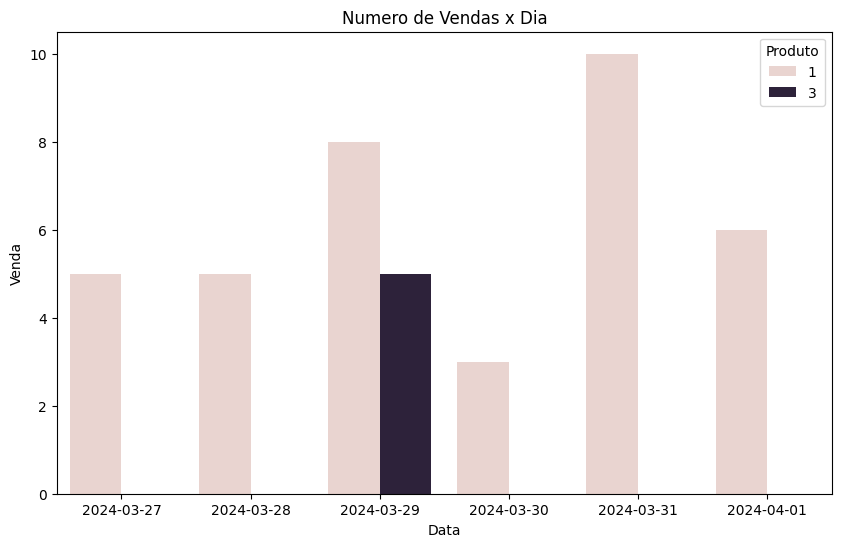

In [4]:
plt.figure(figsize=[10,6])
sns.barplot(data=df_vendas, x='Data', y='Venda', hue='Produto', estimator='sum', errorbar=None)
plt.title('Numero de Vendas x Dia')

In [5]:
periodo = 5
lead_time = 5
confianca = 0.95

In [6]:
vendas_periodo = df_vendas[(pd.Timestamp.today() - df_vendas['Data']).dt.days < periodo].groupby(['Produto'])['Venda'].sum().reset_index().rename(columns={'Venda':'30dias'})
vendas_periodo

,Produto,30dias
0,1,32
1,3,5


In [7]:
df_resume = df_estoque.merge(vendas_periodo, on='Produto', how='left')
df_resume['30dias'] = df_resume['30dias'].replace(np.NAN, 0)
df_resume['Demanda'] = df_resume['30dias'] / periodo
df_resume['Desvio'] = df_vendas.groupby(['Produto'])['Venda'].std().reset_index()['Venda']
df_resume['Desvio'] = df_resume['Desvio'].replace(np.NAN, 0)
df_resume['Reserva'] = st.norm.ppf(confianca) * np.sqrt(df_resume['Desvio'].pow(2)  * lead_time + (df_resume['Demanda'].pow(2)))
df_resume['Minimo'] = df_resume['Demanda'] * lead_time + df_resume['Reserva']
df_resume['Maximo'] = (df_resume['Demanda'] + df_resume['Reserva']) * lead_time

df_resume

,Produto,Compra,Venda,Estoque,30dias,Demanda,Desvio,Reserva,Minimo,Maximo
0,1,200,23.0,177.0,32.0,6.4,3.056868,15.402210,47.402210,109.011048
1,2,150,0.0,150.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,3,60,3.0,57.0,5.0,1.0,0.000000,1.644854,6.644854,13.224268
3,4,150,7.0,143.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Demanda x Produto')

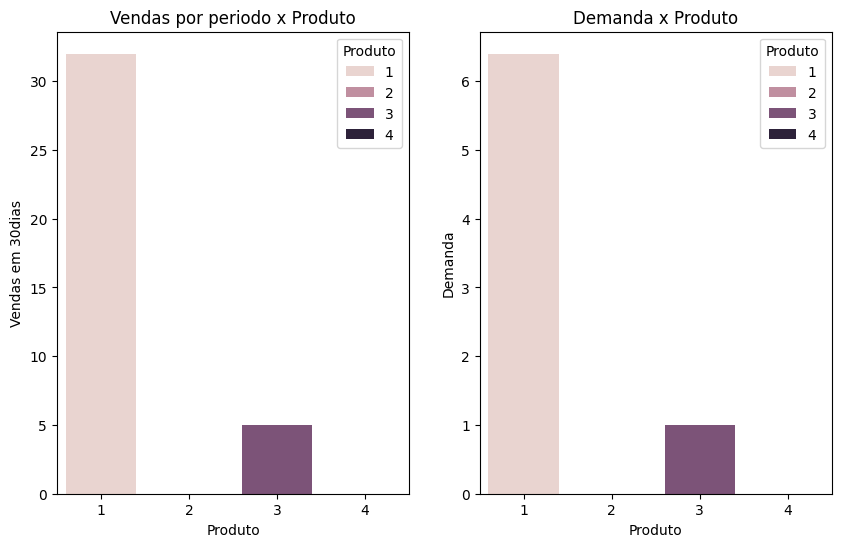

In [8]:
plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
sns.barplot(data=df_resume,x='Produto',y='30dias', hue='Produto')
plt.ylabel('Vendas em 30dias')
plt.title('Vendas por periodo x Produto')

plt.subplot(1,2,2)
sns.barplot(data=df_resume,x='Produto',y='Demanda', hue='Produto')
plt.title('Demanda x Produto')